In [1]:
!pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("aklimarimi/8-facial-expressions-for-yolo")

print("Path to dataset files:", path)

100%|██████████| 3.77G/3.77G [01:38<00:00, 41.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aklimarimi/8-facial-expressions-for-yolo/versions/4


In [2]:
import os

# Constants
IMG_SIZE = 48
# DATA_DIR = '/kaggle/input/8-facial-expressions-for-yolo/9 Facial Expressions you need/'
DATA_DIR = os.path.join(path, '9 Facial Expressions you need') # Use the path returned by kagglehub.dataset_download

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


train = os.listdir(os.path.join(DATA_DIR,'train'))
test = os.listdir(os.path.join(DATA_DIR,'test'))
val=os.listdir(os.path.join(DATA_DIR,'valid'))
print(f'Train - {train}')
print(f'Test - {test}')
print(f'Val - {val}')

Train - ['labels', 'images']
Test - ['labels', 'images']
Val - ['labels', 'images']


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 48
EMOTIONS = ['Happy', 'Sad', 'Angry', 'Surprised', 'Neutral', 'Disgusted', 'Fear', 'Sleepy', 'Contempt']  # update based on your labels
emotion_to_idx = {e: i for i, e in enumerate(EMOTIONS)}
idx_to_emotion = {i: e for i, e in enumerate(EMOTIONS)} # Add mapping from index to emotion

def load_data(folder_path):
    image_dir = os.path.join(folder_path, 'images')
    label_dir = os.path.join(folder_path, 'labels')

    images = []
    labels = []

    # Get list of label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    for label_fname in label_files:
        image_fname = label_fname.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_fname)
        label_path = os.path.join(label_dir, label_fname)

        # Check if the corresponding image file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found for label file {label_path}. Skipping.")
            continue

        # Load image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read image file {image_path}. Skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 48×48
        images.append(img)

        # Load and parse label from YOLO format
        with open(label_path, 'r') as f:
            label_content = f.read().strip()
            # Assuming the first number in the line is the class ID
            try:
                class_id = int(label_content.split()[0])
                labels.append(class_id)
            except (ValueError, IndexError):
                print(f"Warning: Could not parse label from file {label_path}. Content: '{label_content}'. Skipping.")
                images.pop() # Remove the image if label parsing fails
                continue


    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [5]:
# Load full data from train folder
images, labels = load_data(os.path.join(DATA_DIR, 'test'))

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Reduce dataset size
n_train = 5000
n_test = 3000

train_images = images[:n_train]
train_labels = labels[:n_train]
test_images = images[-n_test:]
test_labels = labels[-n_test:]

# Add grayscale channel dimension: (N, 48, 48, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels, num_classes=len(EMOTIONS))
test_labels_categorical = to_categorical(test_labels, num_classes=len(EMOTIONS))

# Final checks
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

Train images shape: (1700, 48, 48, 1)
Test images shape: (1700, 48, 48, 1)
Train labels shape: (1700, 9)
Test labels shape: (1700, 9)


In [6]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 53.1 MB/s eta 0:00:00



=== Running for 10 Qubits ===

Quantum Circuit for 10 Qubits:


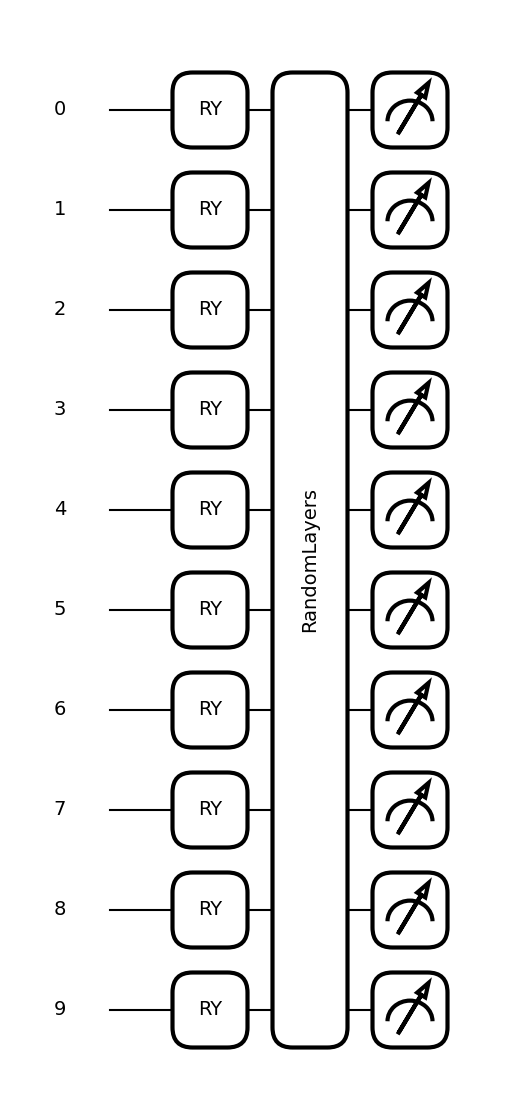

Quantum preprocessing (train)...
Quantum preprocessing (test)...


In [7]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fix random seeds
np.random.seed(0)
tf.random.set_seed(0)

# Number of classes (for this dataset)
num_classes = len(EMOTIONS)

# Define qubit patch sizes
qubit_patch_shapes = {
    4: (2, 2),
    6: (3, 2),
    8: (4, 2),
    10: (5, 2),
    12: (4, 3),
}

# ------------------ Quantum Circuit Creation -------------------
def create_circuit(n_qubits, n_layers=1):
    dev = qml.device("default.qubit", wires=n_qubits)
    rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, n_qubits))

    @qml.qnode(dev)
    def circuit(phi):
        # Encode classical data into qubits
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)
        RandomLayers(rand_params, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    return circuit

# ------------------ Quantum Convolution -------------------
def quanv(image, circuit, patch_h, patch_w):
    out_h = (image.shape[0] - patch_h) // 2 + 1
    out_w = (image.shape[1] - patch_w) // 2 + 1
    n_qubits = patch_h * patch_w
    out = np.zeros((out_h, out_w, n_qubits))
    for j in range(0, image.shape[0] - patch_h + 1, 2):
        for k in range(0, image.shape[1] - patch_w + 1, 2):
            patch = image[j:j+patch_h, k:k+patch_w, 0].flatten()
            q_results = circuit(patch)
            out[j//2, k//2, :] = q_results
    return out

# ------------------ Classical Model -------------------
def build_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ------------------ Run for Multiple Qubits -------------------
results = {}
n_qubits=10 # Changed from list [6] to integer 6

print(f"\n=== Running for {n_qubits} Qubits ===")
patch_h, patch_w = qubit_patch_shapes[n_qubits]
circuit = create_circuit(n_qubits)

# Show quantum circuit diagram
print(f"\nQuantum Circuit for {n_qubits} Qubits:")
fig, ax = qml.draw_mpl(circuit)(np.random.rand(n_qubits))
plt.show()

# Quantum preprocessing
print("Quantum preprocessing (train)...")
q_train_images = np.array([quanv(img, circuit, patch_h, patch_w) for img in train_images])
print("Quantum preprocessing (test)...")
q_test_images = np.array([quanv(img, circuit, patch_h, patch_w) for img in test_images])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/800
213/213 - 6s - 28ms/step - accuracy: 0.2218 - loss: 2.3724 - val_accuracy: 0.2500 - val_loss: 2.0005
Epoch 2/800
213/213 - 2s - 11ms/step - accuracy: 0.2712 - loss: 1.9965 - val_accuracy: 0.3365 - val_loss: 1.8948
Epoch 3/800
213/213 - 2s - 12ms/step - accuracy: 0.3006 - loss: 1.8966 - val_accuracy: 0.3588 - val_loss: 1.7469
Epoch 4/800
213/213 - 3s - 12ms/step - accuracy: 0.3206 - loss: 1.8241 - val_accuracy: 0.3982 - val_loss: 1.7258
Epoch 5/800
213/213 - 3s - 15ms/step - accuracy: 0.3365 - loss: 1.7431 - val_accuracy: 0.4165 - val_loss: 1.6343
Epoch 6/800
213/213 - 2s - 10ms/step - accuracy: 0.3524 - loss: 1.6855 - val_accuracy: 0.4424 - val_loss: 1.5312
Epoch 7/800
213/213 - 2s - 11ms/step - accuracy: 0.3712 - loss: 1.6204 - val_accuracy: 0.4647 - val_loss: 1.4495
Epoch 8/800
213/213 - 2s - 11ms/step - accuracy: 0.3918 - loss: 1.6078 - val_accuracy: 0.4847 - val_loss: 1.4699
Epoch 9/800
213/213 - 3s - 12ms/step - accuracy: 0.4018 - loss: 1.5434 - val_accuracy: 0.4894 - 

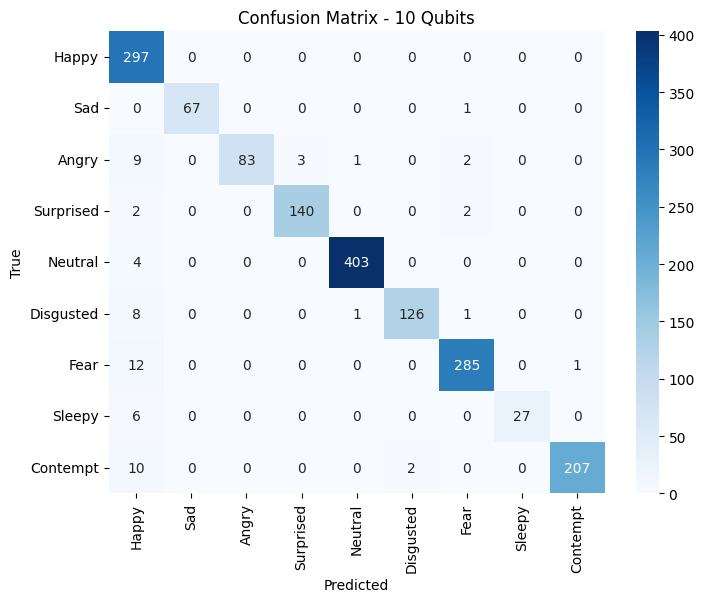

Test Accuracy (10 Qubits): 0.9618


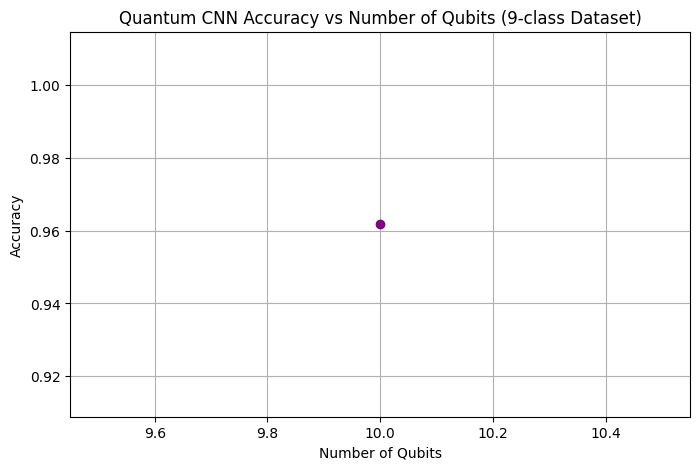


=== Final Accuracy Comparison ===
10 Qubits: Accuracy = 0.9618


In [10]:
# Train classical model
model = build_model(q_train_images.shape[1:], num_classes)
model.fit(q_train_images, train_labels, validation_data=(q_test_images, test_labels),
              epochs=800, batch_size=8, verbose=2)

# Predictions & evaluation
y_pred = np.argmax(model.predict(q_test_images), axis=1)

print(f"\nClassification Report ({n_qubits} Qubits):")
print(classification_report(test_labels, y_pred, target_names=EMOTIONS, labels=range(num_classes)))

    # Confusion Matrix
cm = confusion_matrix(test_labels, y_pred, labels=range(num_classes)) # Add labels parameter here as well
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title(f"Confusion Matrix - {n_qubits} Qubits")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Accuracy
acc = model.evaluate(q_test_images, test_labels, verbose=0)[1]
print(f"Test Accuracy ({n_qubits} Qubits): {acc:.4f}")
results[n_qubits] = acc

# ------------------ Accuracy Comparison Plot -------------------
plt.figure(figsize=(8, 5))
plt.plot(list(results.keys()), list(results.values()), marker='o', color='purple')
plt.title("Quantum CNN Accuracy vs Number of Qubits (9-class Dataset)")
plt.xlabel("Number of Qubits")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("\n=== Final Accuracy Comparison ===")
for q, a in results.items():
    print(f"{q} Qubits: Accuracy = {a:.4f}")

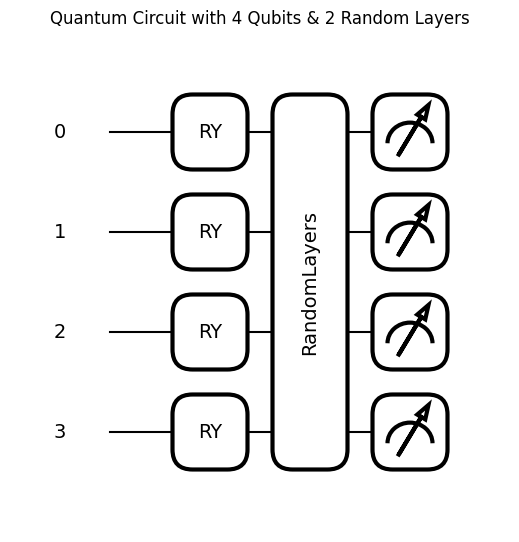

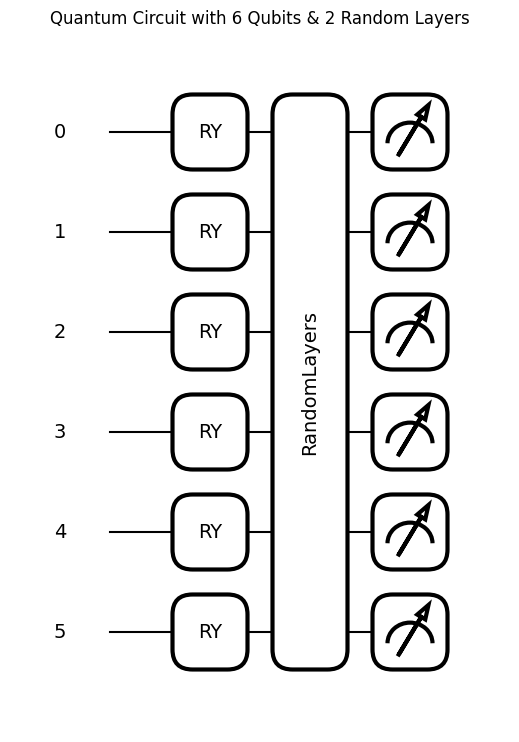

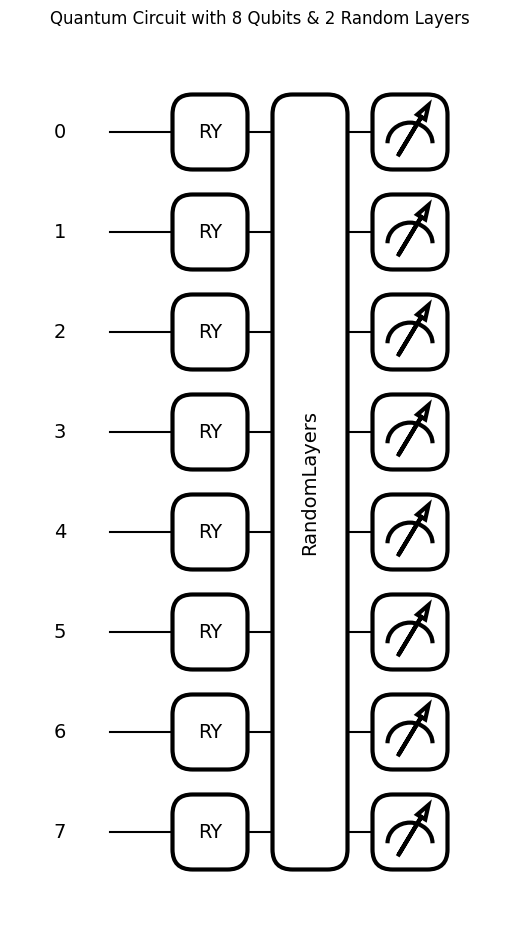

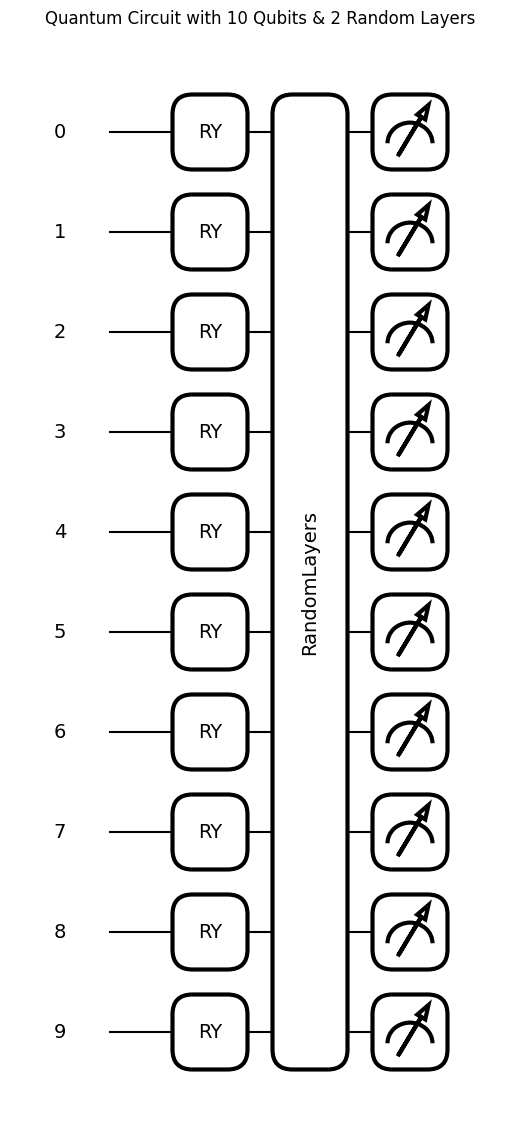

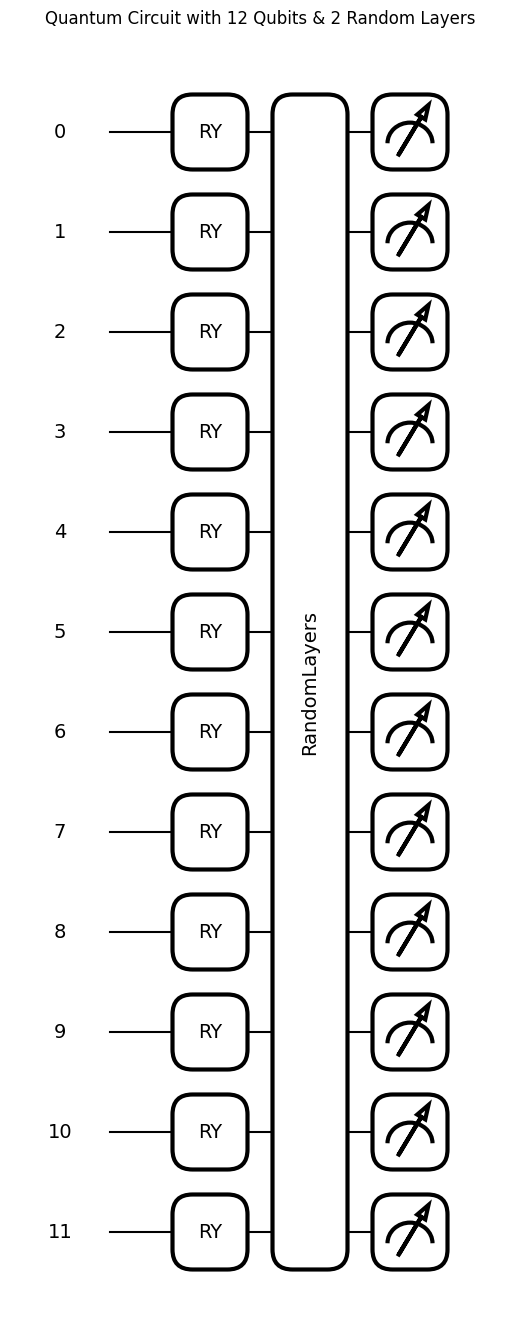

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt

# Function to create and display detailed quantum circuits
def show_detailed_circuit(n_qubits=4, n_layers=2):
    dev = qml.device("default.qubit", wires=n_qubits)

    # Random parameters for encoding & random layers
    rand_params = np.random.uniform(0, 2*np.pi, size=(n_layers, n_qubits))
    sample_inputs = np.random.rand(n_qubits)  # Sample classical input for encoding

    @qml.qnode(dev)
    def circuit(phi):
        # Encoding using RY rotations
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)

        # Apply random entangling layers
        RandomLayers(rand_params, wires=range(n_qubits))

        # Measurement
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    # Draw circuit
    fig, ax = qml.draw_mpl(circuit)(sample_inputs)
    plt.title(f"Quantum Circuit with {n_qubits} Qubits & {n_layers} Random Layers")
    plt.show()

# Show circuits for 4, 6, 8, 10, 12 qubits
for q in [4, 6, 8, 10, 12]:
    show_detailed_circuit(n_qubits=q, n_layers=2)